In [2]:
import numpy as np
import pandas as pd
from shutil import copyfile
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from spec_tools import Source_present, Photometry, Scale_model, Oldest_galaxy,Smooth
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 


In [3]:
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [4]:
def Stack(wv,flgrid,errgrid,contam):
#     for i in range(len(flgrid)):
#         flgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 0
#         errgrid[i][contam[i]**2 / (errgrid[i]**2 - contam[i]**2) > 1] = 1E5
    
    
    flgrid = np.transpose(flgrid)
    errgrid = np.transpose(errgrid)
    weigrid = errgrid ** (-2)
    infmask = np.isinf(weigrid)
    weigrid[infmask] = 0
    ################

    stack, err = np.zeros([2, len(wv)])
    for i in range(len(wv)):
        stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
        err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
    
    return stack, err

In [198]:
# grp = multifit.GroupFLT(grism_files = glob(dpath+'Grism_fields/GS3/*GrismFLT.fits'))

beams = grp.get_beams(42113, size=80)
mb = multifit.MultiBeam(beams, fcontam=1.0)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1200: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:2948: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  out = np.linalg.lstsq(A.T,y)


In [199]:
g102 = mb.oned_spectrum()['G102']
g141 = mb.oned_spectrum()['G141']

Bwv = g102['wave']
Bflx = g102['flux'] / g102['flat']
Berr = g102['err'] / g102['flat']
Bflt = g102['flat']

Rwv = g141['wave']
Rflx = g141['flux'] / g141['flat']
Rerr = g141['err'] / g141['flat']
Rflt = g141['flat']

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


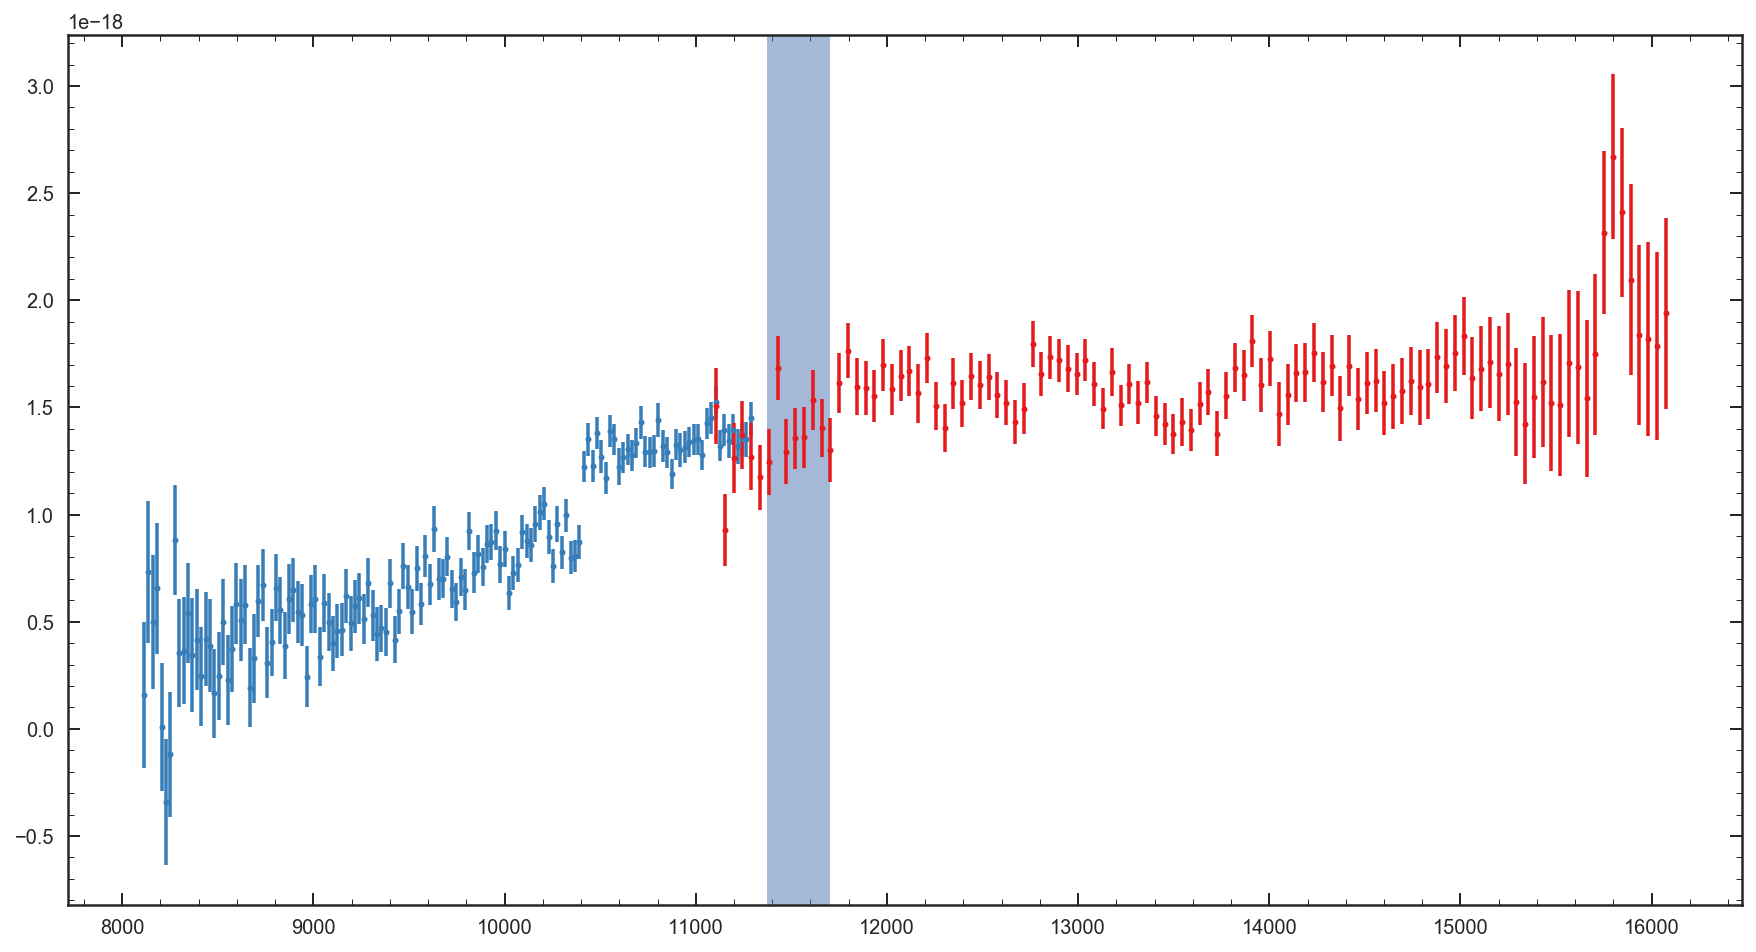

In [200]:
plt.figure(figsize=[15,8])

IDB = [U for U in range(len(Bwv)) if 8100 < Bwv[U] < 11300]
IDR = [U for U in range(len(Rwv)) if 11100 < Rwv[U] < 16100]

plt.errorbar(Bwv[IDB],Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
# plt.plot(Bwv, Smooth(sp.Bflx,sp.Bwv),'k', linewidth=3)
plt.errorbar(Rwv[IDR],Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.axvspan(11375,11700,alpha=0.5)

In [201]:
def Get_spec(beam):
#     xspec, yspec, yerr = beam.beam.optimal_extract(beam.grism.data['SCI'], bin=0, ivar=beam.ivar) #data

    xspec, yspec, yerr = beam.beam.optimal_extract(beam.grism.data['SCI'] - beam.contam, bin=0, ivar=beam.ivar) #data
    xspecc, yspecc, yerrc = beam.beam.optimal_extract(beam.contam, bin=0, ivar=beam.ivar)
    is_g102 = 'none'
    
    IDB = [U for U in range(len(Bwv)) if 10000 < Bwv[U] < 11300]
    IDR = [U for U in range(len(Rwv)) if 14000 < Rwv[U] < 16000]
    if max(xspec) < 16000:
        ispec = interp1d(xspec,yspec)(Bwv)
        ierr = interp1d(xspec,np.sqrt(yerr**2 + yspecc**2))(Bwv)
        icontam = interp1d(xspec, yspecc)(Bwv)
        
        is_g102 = True

        flux = ispec / Bflt
        error = ierr / Bflt
        contam = icontam / Bflt
        
        error[flux**2 > 1] = 1E-15
        error[~(flux**2 > 0)] = 1E-15
        
        contam[flux**2 > 1] = 0
        contam[~(flux**2 > 0)] = 0
        
        flux[flux**2 > 1] = 0
        flux[~(flux**2 > 0)] = 0
        
        mod = np.trapz(flux[IDB],Bwv[IDB])
#         mod=1
        flux /= mod
        error /= mod
        contam /= mod
    else:
        ispec = interp1d(xspec,yspec)(Rwv)       
        ierr = interp1d(xspec,np.sqrt(yerr**2 + yspecc**2))(Rwv)
        icontam = interp1d(xspec, yspecc)(Rwv)

        is_g102 = False

        flux = ispec / Rflt
        error = ierr / Rflt
        contam = icontam / Rflt

        error[flux**2 > 1] = 1E-16
        error[~(flux**2 > 0)] = 1E-16
        
        contam[flux**2 > 1] = 0
        contam[~(flux**2 > 0)] = 0
                
        flux[flux**2 > 1] = 0
        flux[~(flux**2 > 0)] = 0
        
        mod = np.trapz(flux[IDR],Bwv[IDR])
        
        flux /= mod
        error /= mod
        contam /= mod
        
    return flux, error, is_g102, contam


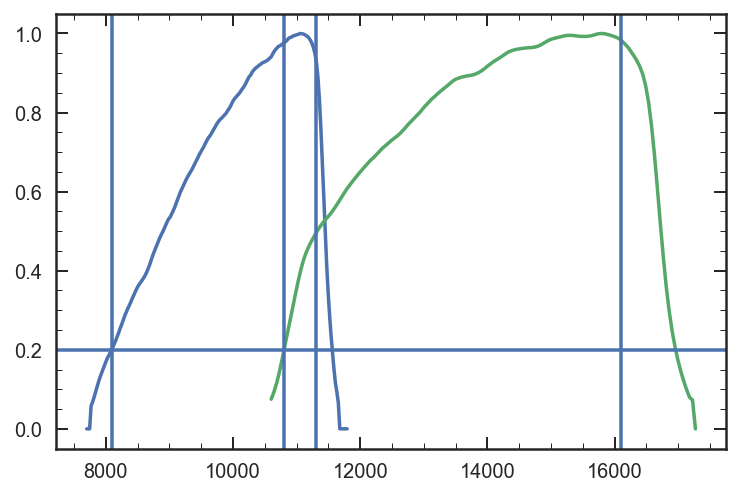

In [202]:
plt.plot(Bwv,Bflt / max(Bflt))
plt.plot(Rwv,Rflt / max(Rflt))
plt.axhline(0.2)
plt.axvline(8100)
plt.axvline(11300)
plt.axvline(10800)
plt.axvline(16100)

In [203]:
Bsps= []
Bers = []
Bcon = []
Rsps= []
Rers = []
Rcon = []

for i in beams:
    s,e,flg,contam = Get_spec(i)
    if flg:
        Bsps.append(s)
        Bers.append(e)
        Bcon.append(contam)
    else:
        Rsps.append(s)
        Rers.append(e)
        Rcon.append(contam)
        
Bsps = np.array(Bsps)
Bers = np.array(Bers)
Bcon = np.array(Bcon)
Rsps = np.array(Rsps)
Rers = np.array(Rers)
Rcon = np.array(Rcon)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in true_divide
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:594: RuntimeWarning: invalid value encountered in true_divide
  opt_flux = num.sum(axis=0)/den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:595: RuntimeWarning: divide by zero encountered in true_divide
  opt_var = 1./den.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/pyt

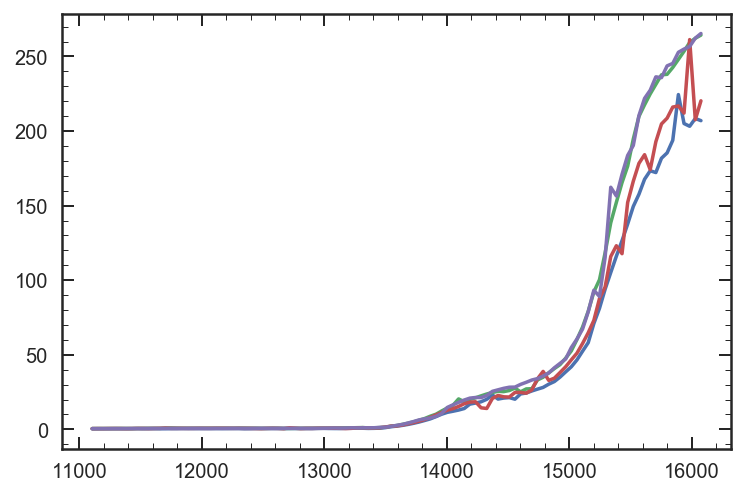

In [204]:
for i in range(len(Rcon)):
    plt.plot(Rwv[IDR],Rcon[i][IDR]**2/ ( Rers[i][IDR]**2 - Rcon[i][IDR]**2))    


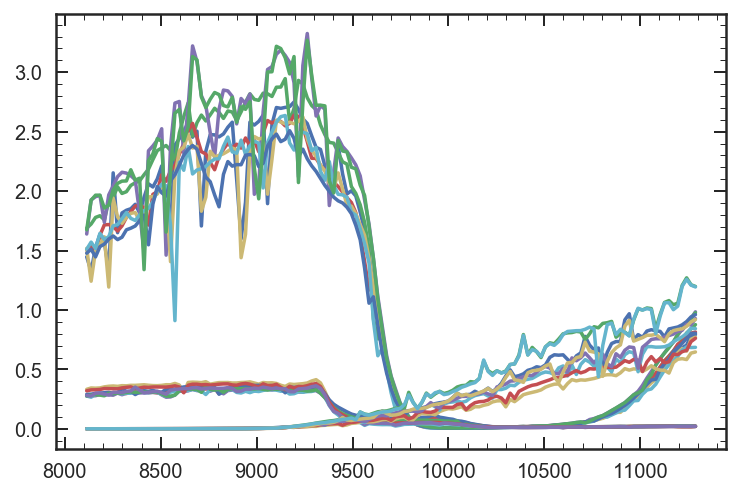

In [205]:
for i in range(len(Bcon)):
    plt.plot(Bwv[IDB],Bcon[i][IDB]**2/ (Bers[i][IDB]**2 - Bcon[i][IDB]**2))  

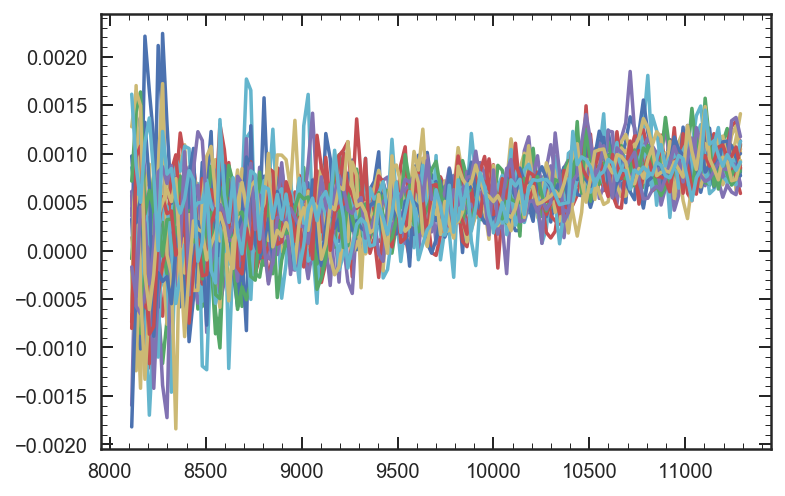

In [206]:
for i in Bsps:
    plt.plot(Bwv[IDB],i[IDB]+1E-15)

In [207]:
Bstk, Bser = Stack(Bwv,Bsps + np.mean(Bsps),Bers ,Bcon)
Rstk, Rser = Stack(Rwv,Rsps + np.mean(Rsps),Rers,Rcon)


<ErrorbarContainer object of 3 artists>

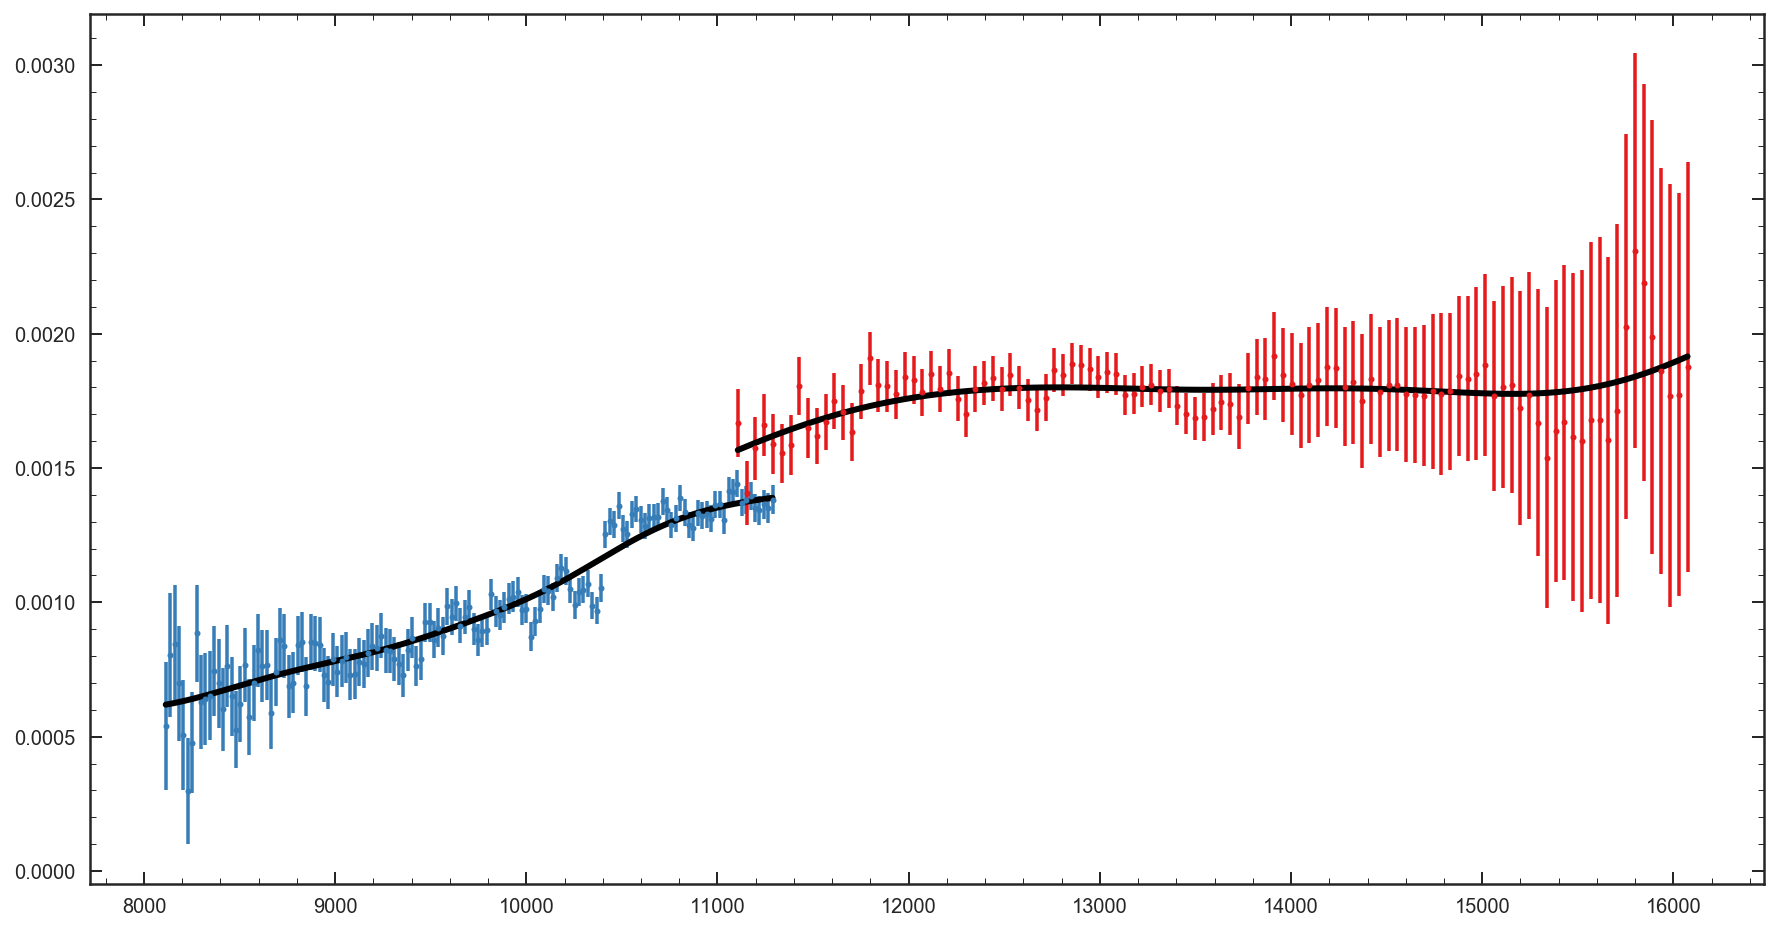

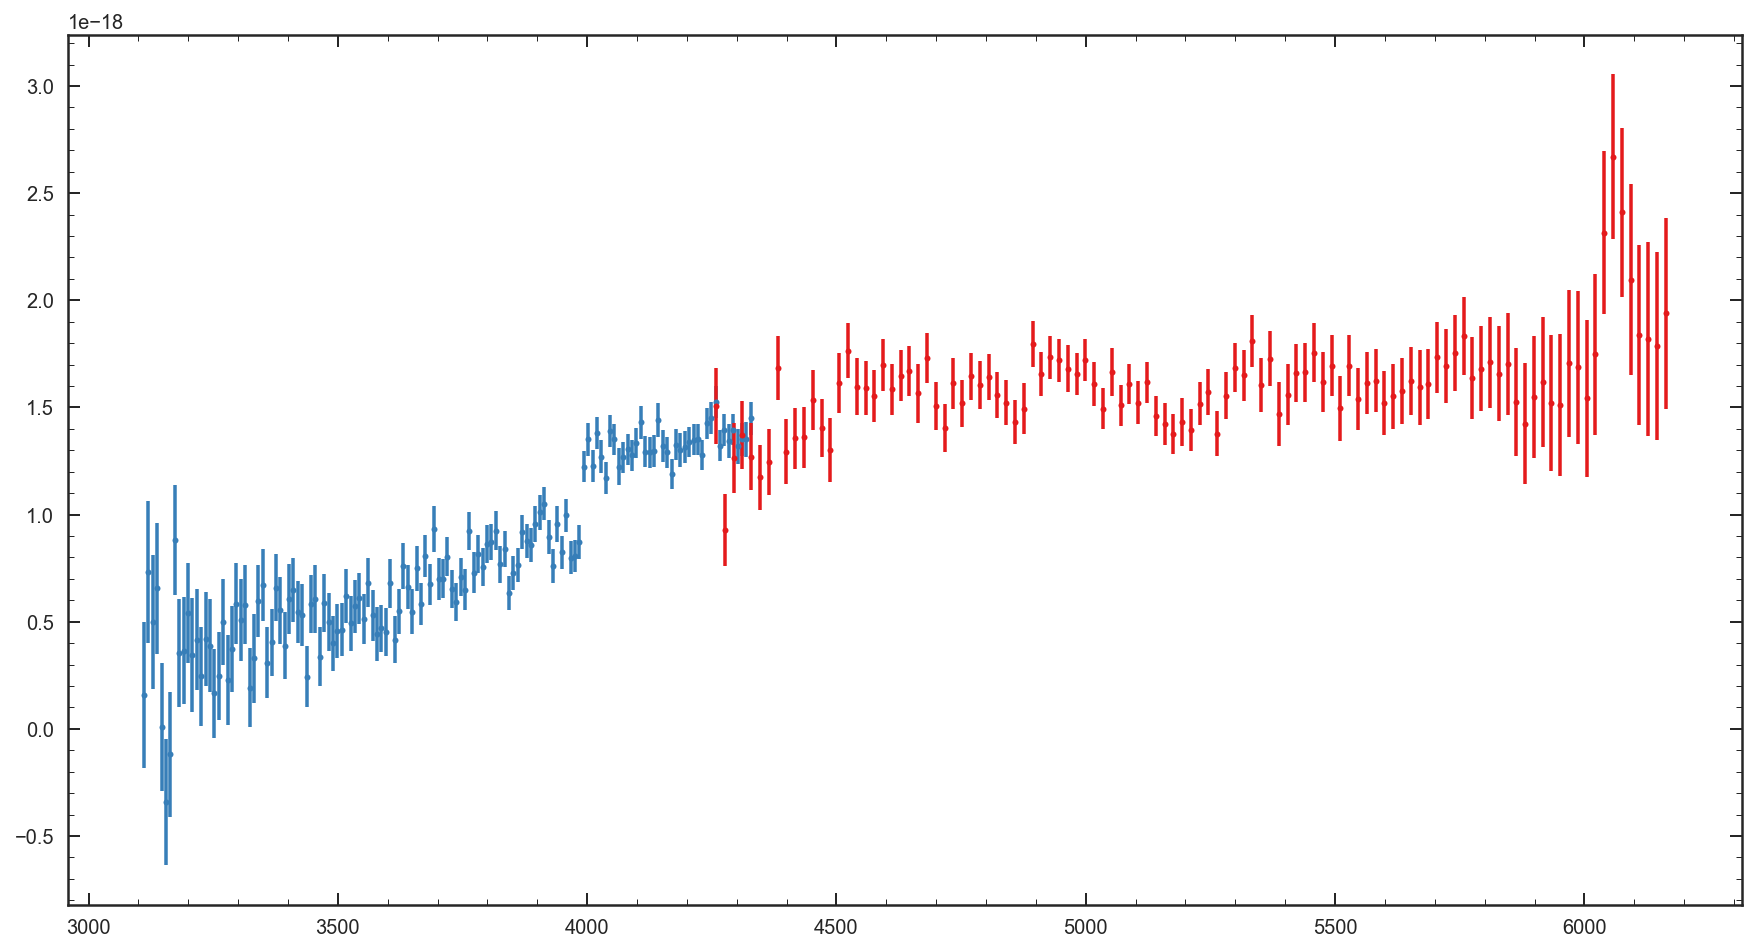

In [208]:
plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB],Bstk[IDB],Bser[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rstk[IDR],Rser[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(Bwv[IDB],Smooth(Bstk[IDB],Bwv[IDB]),'k',linewidth=3)
plt.plot(Rwv[IDR],Smooth(Rstk[IDR],Rwv[IDR]),'k',linewidth=3)


# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)
# plt.text(3890,3.6,'Ca HK',fontsize=20)
# plt.text(4080,3.6,'H$\delta$',fontsize=20)
# plt.text(4275,3.6,'G+H$\gamma$',fontsize=20)
# plt.text(4830,3.6,'H$\\beta$',fontsize=20)
# plt.text(5160,5.6,'Mgb',fontsize=20)
# plt.axvspan(11375,11700,alpha=0.5)

# plt.figure(figsize=[15,8])
# plt.errorbar(Bwv[IDB]/(2.413),Bstk[IDB],Bser[IDB],
#             linestyle='None', marker='o', markersize=3, color='#377eb8')
# plt.errorbar(Rwv[IDR]/(2.413),Rstk2[IDR],Rser2[IDR],
#             linestyle='None', marker='o', markersize=3, color='#e41a1c')
# # plt.axvspan(11375,11700,alpha=0.5)

# plt.ylim(0,3E-3)

plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB]/(2.608),Bflx[IDB],Berr[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR]/(2.608),Rflx[IDR],Rerr[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
# plt.axvspan(11375,11700,alpha=0.5)



(0, 2)

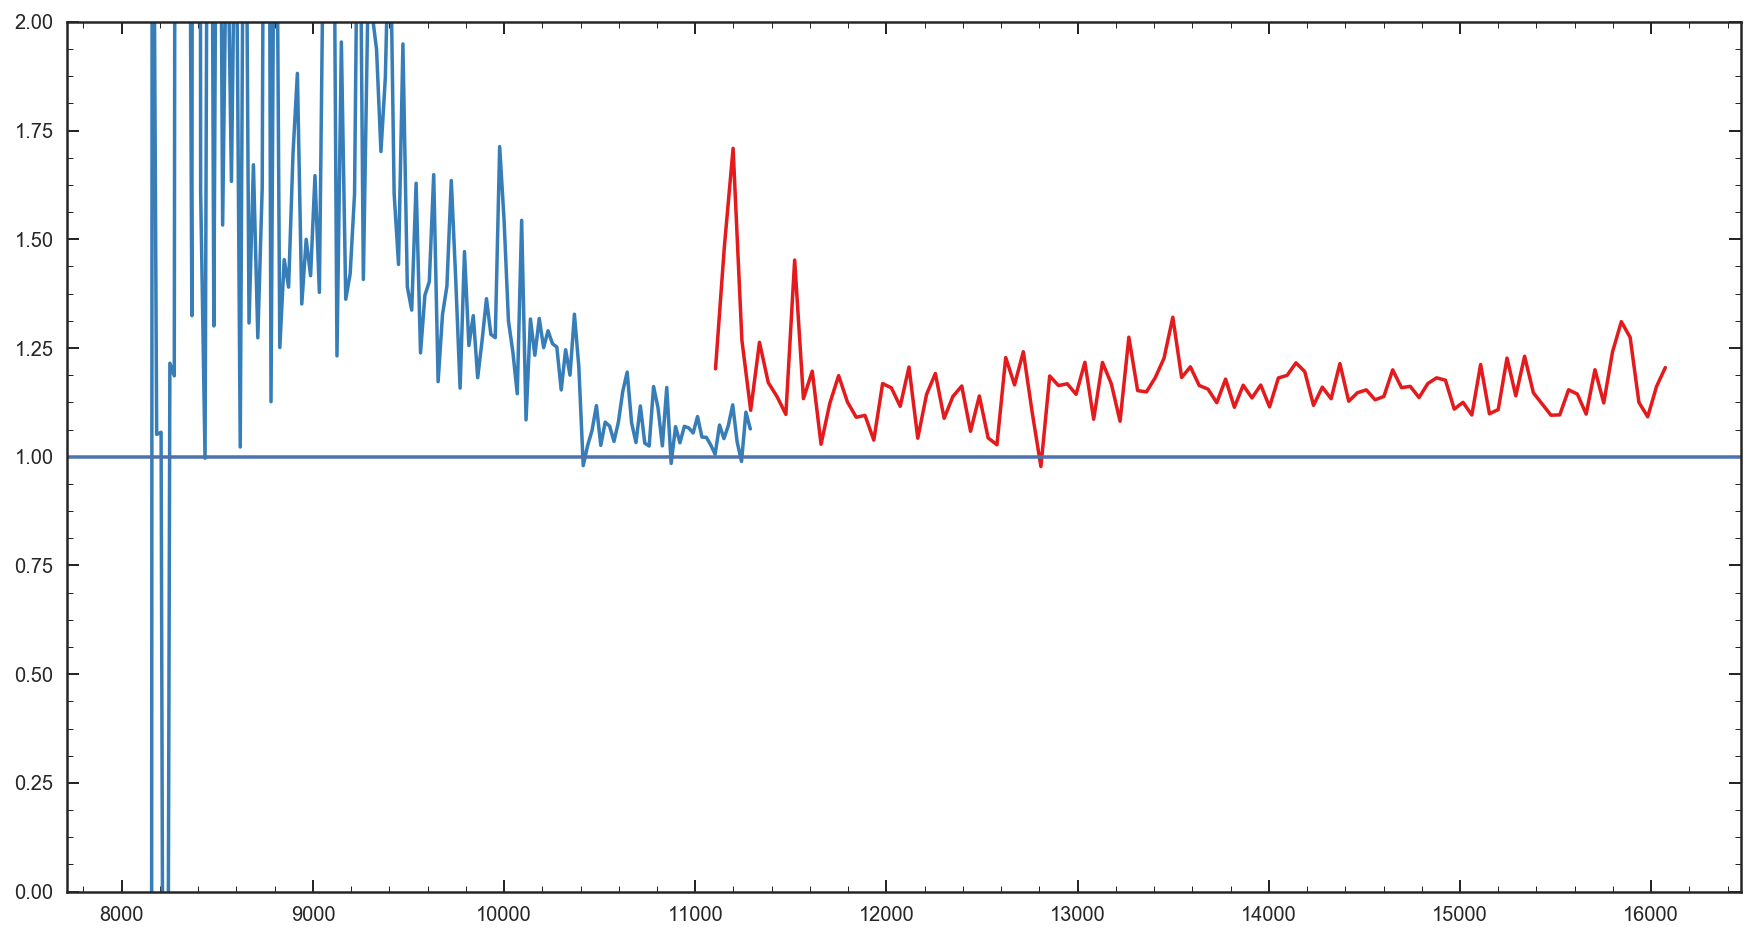

In [182]:
plt.figure(figsize=[15,8])
plt.plot(Bwv[IDB],Bstk[IDB]/Bflx[IDB] * np.max(Bflx[IDB])/np.max(Bstk[IDB]) , color='#377eb8')
plt.plot(Rwv[IDR],Rstk[IDR]/Rflx[IDR] * np.max(Rflx[IDR])/np.max(Rstk[IDR]) , color='#e41a1c')
plt.axhline(1)
plt.ylim(0,2)

(8000, 16200)

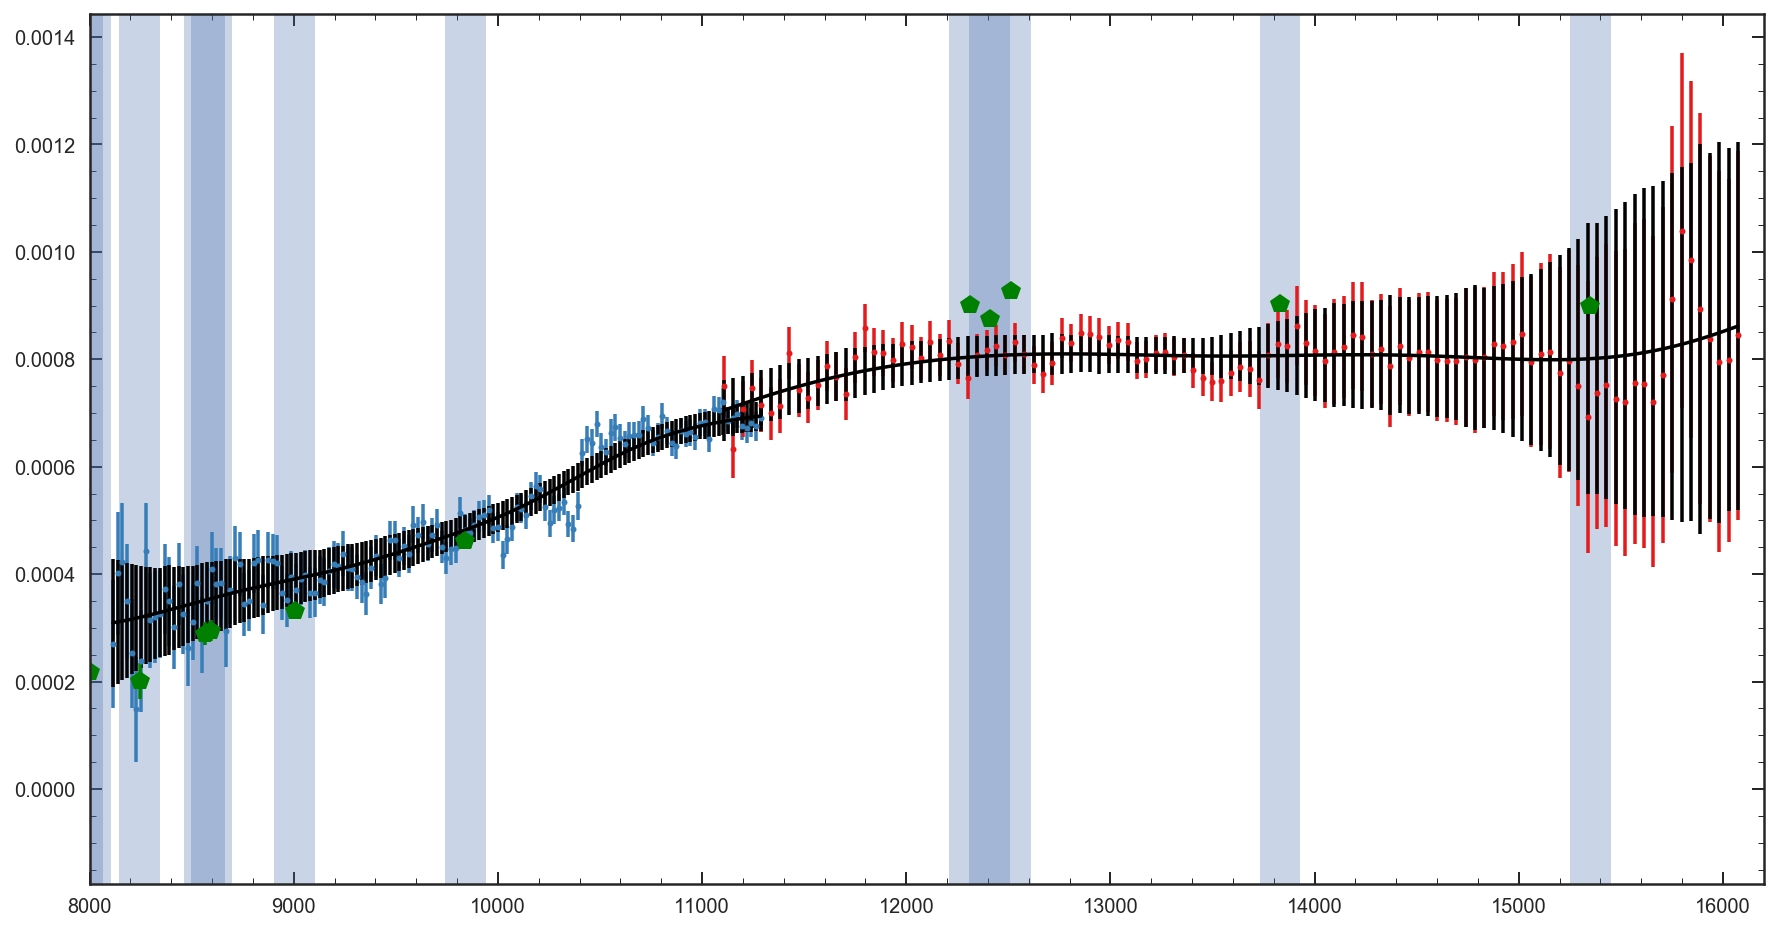

In [209]:
Pwv, Pflx, Perr, Pnum = np.load('../phot/GSD_41520_phot.npy')

plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB],Bstk[IDB]*0.5,Bser[IDB]*0.5,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rstk[IDR]*0.45,Rser[IDR]*0.45,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

plt.errorbar(Bwv[IDB],Smooth(Bstk[IDB],Bwv[IDB])*0.5,Bser[IDB]*0.5,color='k')
plt.errorbar(Rwv[IDR],Smooth(Rstk[IDR],Rwv[IDR])*0.45,Rser[IDR]*0.45,color='k')
plt.errorbar(Pwv, Pflx*9E14, Perr*5E14,
            linestyle='None', marker='p', markersize=10, color='G')

for i in Pwv:
    plt.axvspan(i - 100 , i +100, alpha=0.3)

plt.xlim(8000,16200)

(8000, 16200)

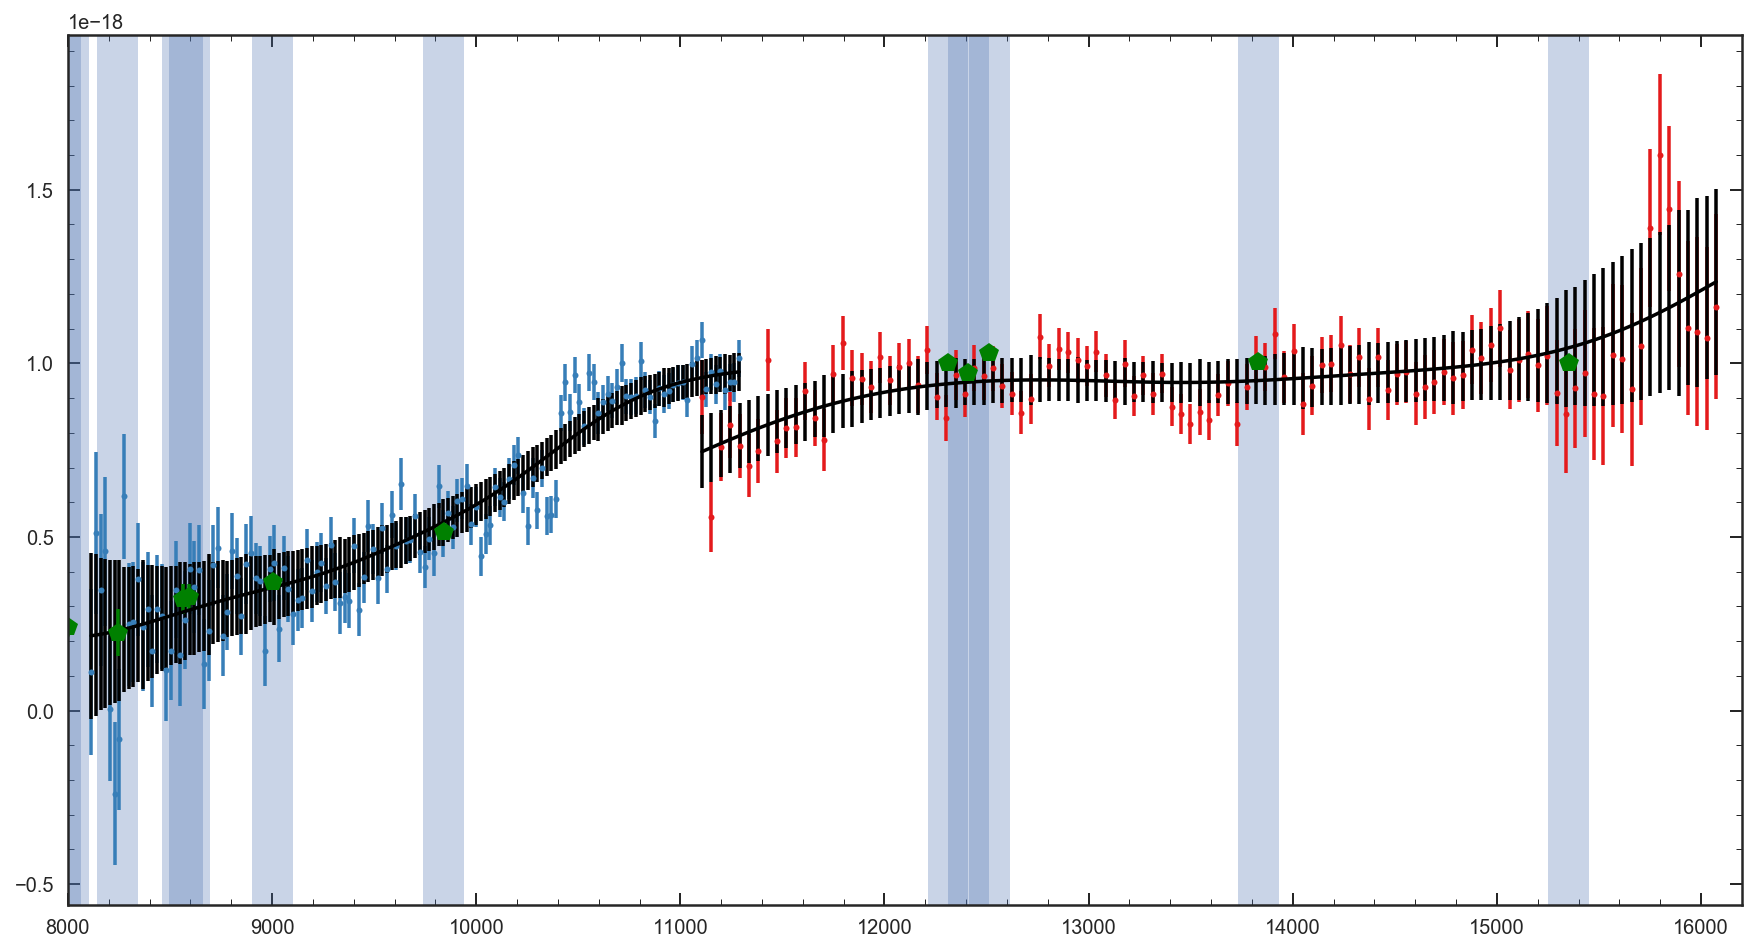

In [218]:
Pwv, Pflx, Perr, Pnum = np.load('../phot/GSD_41520_phot.npy')

plt.figure(figsize=[15,8])
plt.errorbar(Bwv[IDB],Bflx[IDB]*0.7,Berr[IDB]*0.7,
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.errorbar(Rwv[IDR],Rflx[IDR]*0.6,Rerr[IDR]*0.6,
            linestyle='None', marker='o', markersize=3, color='#e41a1c')

plt.errorbar(Bwv[IDB],Smooth(Bflx[IDB]*0.7,Bwv[IDB]),Berr[IDB]*0.7,color='k')
plt.errorbar(Rwv[IDR],Smooth(Rflx[IDR]*0.6,Rwv[IDR]),Rerr[IDR]*0.6,color='k')

plt.errorbar(Pwv, Pflx, Perr,
            linestyle='None', marker='p', markersize=10, color='G')

for i in Pwv:
    plt.axvspan(i - 100 , i +100, alpha=0.3)


plt.xlim(8000,16200)

<ErrorbarContainer object of 3 artists>

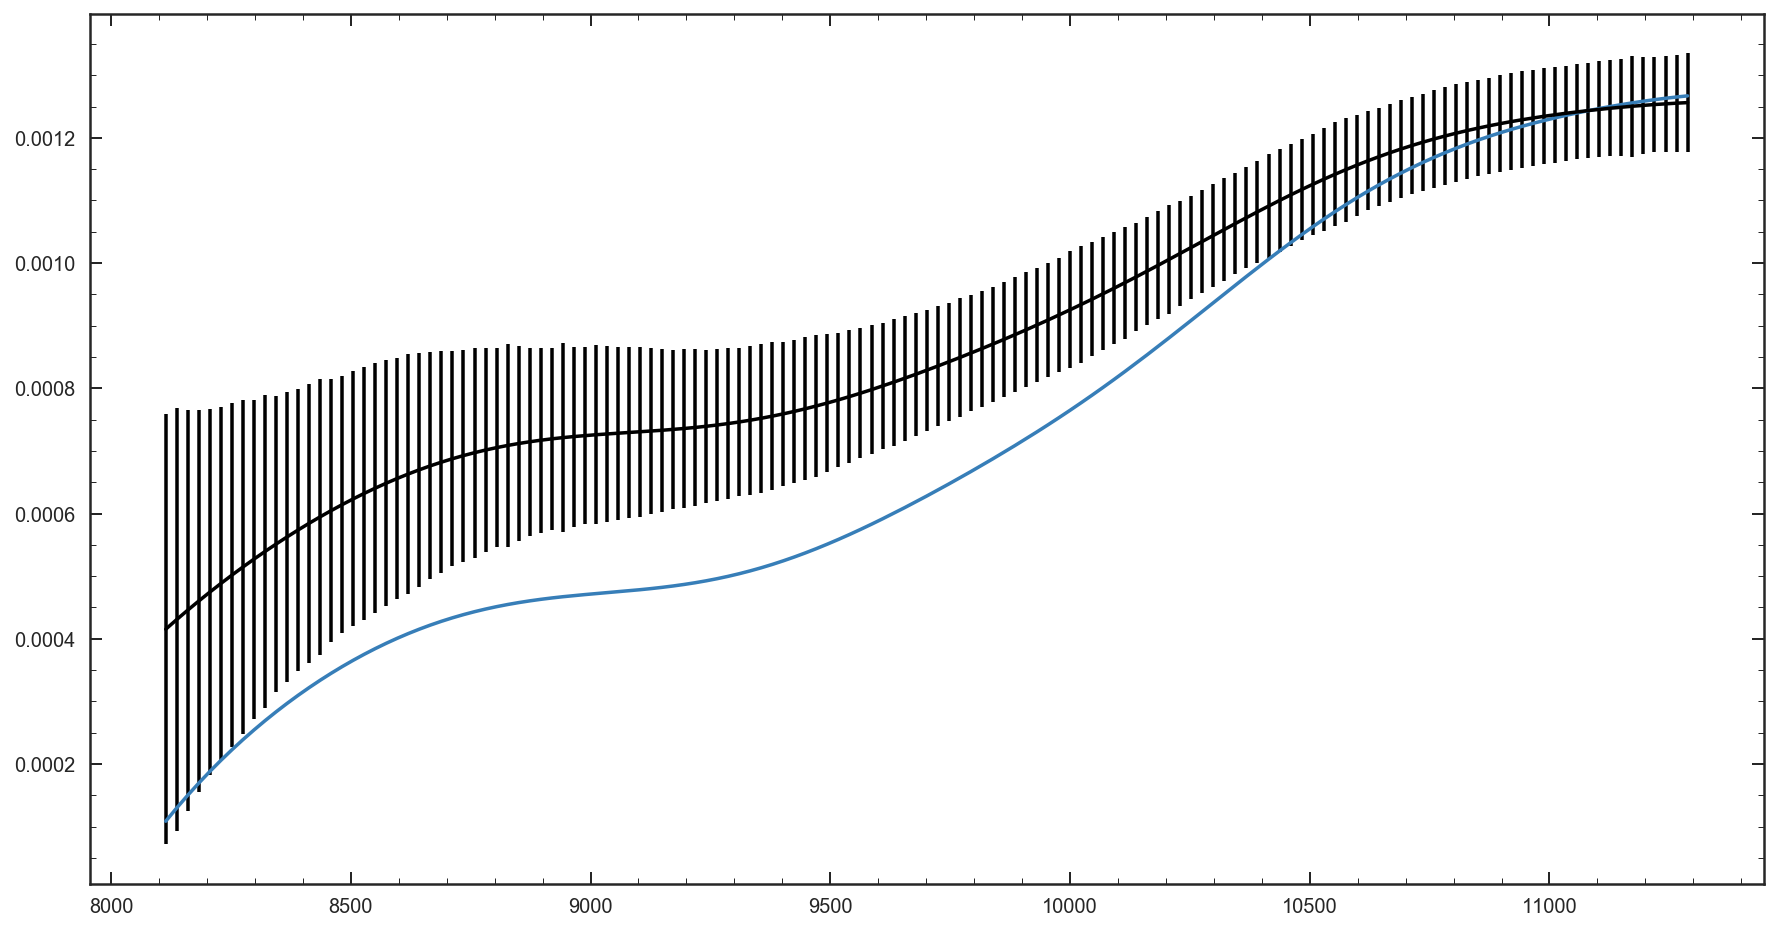

In [163]:
plt.figure(figsize=[15,8])
plt.plot(Bwv[IDB],Smooth(Bflx[IDB] * np.max(Bstk[IDB]) / np.max(Bflx[IDB]),Bwv[IDB]), color='#377eb8')
# plt.plot(Bwv[IDB],Smooth(Bstk[IDB],Bwv[IDB])*1.1, color='k')
plt.errorbar(Bwv[IDB],Smooth(Bstk[IDB],Bwv[IDB])*0.95,Bser[IDB],color='k')

# plt.scatter(Rwv[IDR],Rflx[IDR] * np.max(Rstk[IDR]) / np.max(Rflx[IDR]) - Rstk[IDR], color='#e41a1c')
# plt.ylim(0,12E-4)

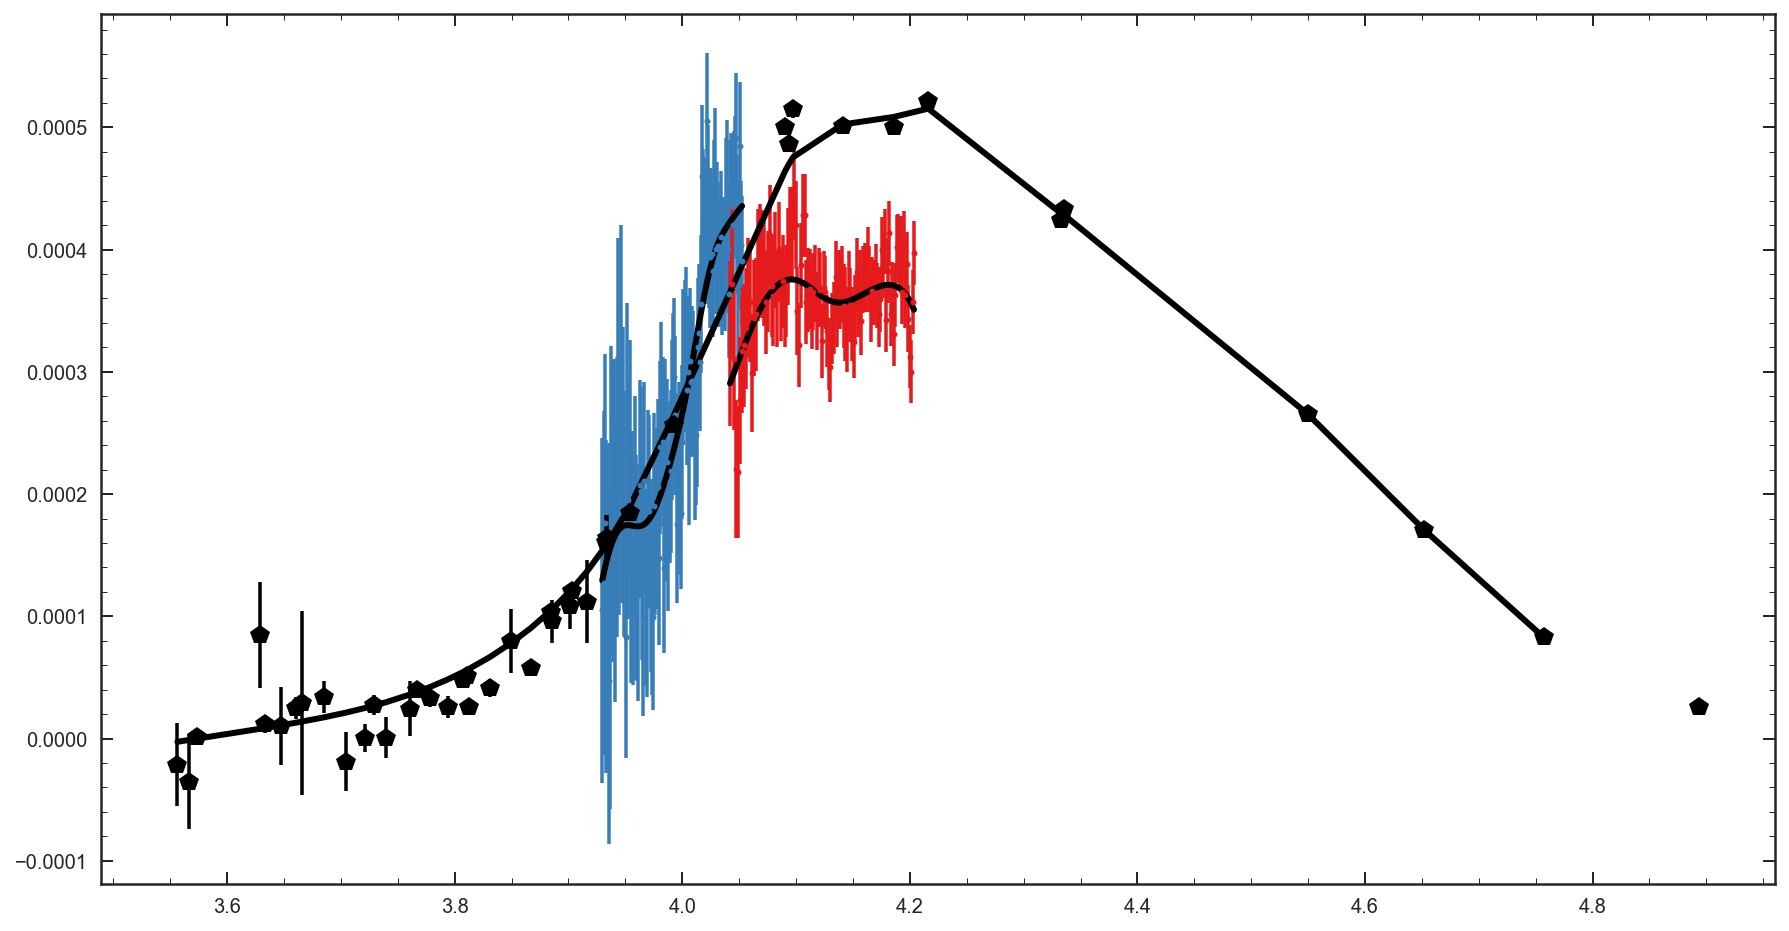

In [27]:
Pwv, Pflx, Perr, Pnum = np.load('../phot/GSD_41520_phot.npy')
def Smooth(f,x):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    fx = ksmooth.locpoly(x,f,bandwidth = H)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

plt.figure(figsize=[15,8])
plt.errorbar(np.log10(Bwv[IDB]),Bstk[IDB]*.8,Bser[IDB],
            linestyle='None', marker='o', markersize=3, color='#377eb8')
plt.plot(np.log10(Bwv[IDB]), Smooth(Bstk[IDB], Bwv[IDB])*.8,'k', linewidth=3)

plt.errorbar(np.log10(Rwv[IDR]),Rstk[IDR]*.9,Rser[IDR],
            linestyle='None', marker='o', markersize=3, color='#e41a1c')
plt.plot(np.log10(Rwv[IDR]), Smooth(Rstk[IDR], Rwv[IDR])*.9,'k', linewidth=3)
plt.errorbar(np.log10(Pwv), Pflx*5E14, Perr*5E14,
            linestyle='None', marker='p', markersize=10, color='k')
plt.plot(np.log10(Pwv[np.argsort(Pwv)]), Smooth(Pflx[np.argsort(Pwv)]*5E14, Pwv[np.argsort(Pwv)]),'k', linewidth=3)

# plt.axvline(3934.777,linestyle='--', alpha=.3)
# plt.axvline(3969.588,linestyle='--', alpha=.3)
# plt.axvline(4102.89,linestyle='--', alpha=.3)
# plt.axvline(4305.61,linestyle='--', alpha=.3)
# plt.axvline(4341.68,linestyle='--', alpha=.3)
# plt.axvline(4862.68,linestyle='--', alpha=.3)
# plt.axvline(5176.7,linestyle='--', alpha=.3)
# plt.axvspan(3910, 3980, color='k', alpha=.1)
# plt.axvspan(3980, 4030, color='k', alpha=.1)
# plt.axvspan(4080, 4120, color='k', alpha=.1)
# plt.axvspan(4250, 4380, color='k', alpha=.1)
# plt.axvspan(4810, 4910, color='k', alpha=.1)
# plt.axvspan(5120, 5240, color='k', alpha=.1)



In [31]:
grp.beams.beam.cutout_from_full_image()

AttributeError: 'GroupFLT' object has no attribute 'beams'

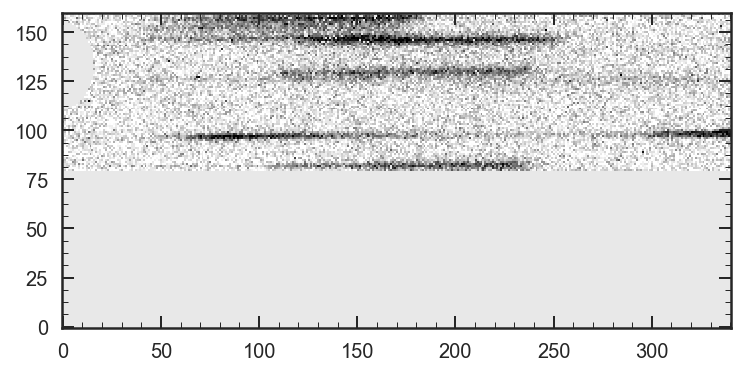

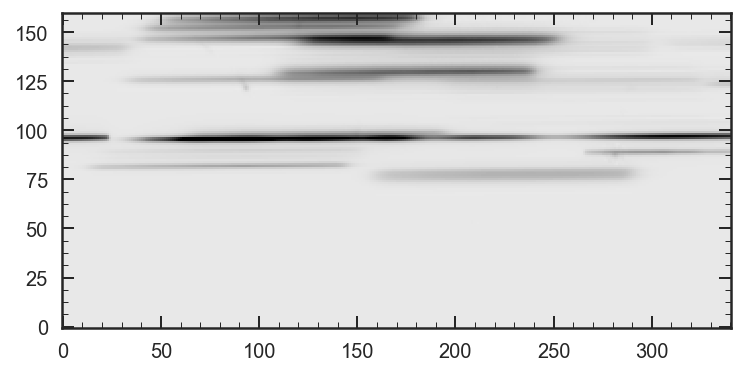

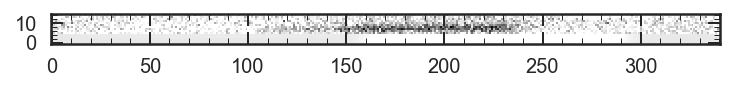

In [66]:
plt.figure()
plt.imshow(grp.beams[-3].grism.data['SCI'], interpolation='none', vmin=-0.02, vmax=0.2, origin='lower',cmap='gray_r')
plt.figure()
plt.imshow(grp.beams[-3].contam, interpolation='none', vmin=-0.02, vmax=0.2, origin='lower',cmap='gray_r')
plt.figure()
plt.imshow(grp.beams[-3].grism.data['SCI'][75:90] - grp.beams[-3].contam[75:90], interpolation='none', vmin=-0.02, vmax=0.2, origin='lower',cmap='gray_r')

In [76]:
xspec, yspec, yerr = grp.beams[-3].beam.optimal_extract(grp.beams[-3].grism.data['SCI'][75:90], bin=0, ivar=grp.beams[-3].ivar[75:90]) #data



`data` (15,341) must have the same shape as the data array (160,341)
            


TypeError: 'bool' object is not iterable